In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

from gsw import sigma2, SA_from_SP, p_from_z, rho

import cosima_cookbook as cc
import gcm_filters
import os

import pandas as pd

import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46201,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:39153,Total threads: 4
Dashboard: /proxy/37123/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:33357,


In [3]:
start_time, end_time = '2071-01-01', '2100-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [8]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/g/data/hh5/tmp/db6174/mom6/archive/databases/cc_database_RYF_control.db'

#db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [9]:
x_min_subtropics, x_max_subtropics = -100, 0
y_min_subtropics, y_max_subtropics = 10, 52

x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

In [10]:
def da_north_atlantic_mask_vmo(da):
    ht = cc.querying.getvar(expt[2], 'deptho', session, n = -1)
    ht = grid.interp(ht, 'X', boundary = 'fill')
    ht = grid.interp(ht, 'Y', boundary = 'fill')
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
    indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xq > -280).where(land_mask.xq < -65)).fillna(0)
    indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xq > -280).where(land_mask.xq < -83.7)).fillna(0)
    indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xq > -280).where(land_mask.xq < -93.3)).fillna(0)
    indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xq > -280).where(land_mask.xq < -99)).fillna(0)
    indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xq > 25).where(land_mask.xq < 80)).fillna(0)
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
    
    north_atlantic_sector_mask = atlantic_sector_mask.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return da * north_atlantic_sector_mask

In [11]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)

In [12]:
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time').load()
Ψ_NA_tmean = Ψ_NA_tmean.where(~np.isnan(vmo_2d_NA.isel(time = 0))).load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean)).load()

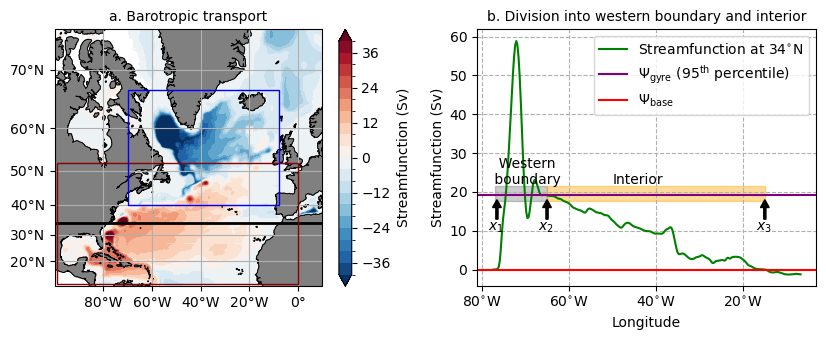

In [19]:
fig = plt.figure()
fig.set_figheight(2.5 * 1.4)
fig.set_figwidth(6 * 1.4)

my_xticks = [-80, -60, -40, -20, 0]
my_yticks = [20, 30, 40, 50, 60, 70]

## Latitude chosen for example
y_ex = 34

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
ax1 = plt.subplot2grid(shape = (1, 4), loc = (0, 0), rowspan = 1, colspan = 2, projection = projection)

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

Ψ_NA_tmean.rename('Streamfunction (Sv)').plot.contourf(ax = ax1, x = 'xq', y = 'yq', cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                         levels = np.linspace(-40, 40, 21), add_colorbar = True, rasterized = True, zorder = -20)

ax1.add_patch(mpatches.Rectangle(xy = [-100, y_ex], width = 110, height = 0.1, facecolor = (1,0,0,0), edgecolor = 'black', linewidth = 2,
                                fill = True, zorder = 2, transform = ccrs.PlateCarree()))

ax1.add_patch(mpatches.Rectangle(xy = [x_min_subtropics + 1, y_min_subtropics + 1], width = x_max_subtropics - x_min_subtropics - 1, 
                                 height = y_max_subtropics - y_min_subtropics - 1, facecolor = (1,0,0,0), edgecolor = 'darkred', linewidth = 1,
                                fill = True, zorder = 2, transform = ccrs.PlateCarree()))

ax1.add_patch(mpatches.Rectangle(xy = [x_min_subpolar, y_min_subpolar], width = x_max_subpolar - x_min_subpolar, 
                                 height = y_max_subpolar - y_min_subpolar, facecolor = (1,0,0,0), edgecolor = 'blue', linewidth = 1,
                                fill = True, zorder = 2, transform = ccrs.PlateCarree()))

# axvspan without transform, adjust ymin/ymax as normalized coordinates
#ax1.axvspan(xmin=-90, xmax=-75.35, ymin=0.2, ymax=0.25, color='black', alpha=0.2, zorder=2)
#ax1.axvspan(xmin=-75.35, xmax=-12.8, ymin=0.42, ymax=0.48, color='orange', alpha=0.4, zorder=2)

ax1.set_yticks(my_yticks, crs = ccrs.PlateCarree())
ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax1.set_ylabel('')

ax1.set_xticks(my_xticks, crs = ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax1.set_xlabel('')

ax1.set_title('a. Barotropic transport', fontsize = 10)

ax1 = plt.subplot2grid(shape = (1, 4), loc = (0, 2), rowspan = 1, colspan = 2)

Ψ_95 = 19.18
Ψ_base = 0
Ψ_NA_tmean.sel(yq = y_ex, method = 'nearest').plot(color = 'green', label = 'Streamfunction at 34$^{\circ}$N')
ax1.axhline(Ψ_95, color = 'purple', label = r'$\Psi_{\mathrm{gyre}}$ (95$^{\mathrm{th}}$ percentile)')
ax1.axhline(Ψ_base, color='red', label = r'$\Psi_{\mathrm{base}}$')

ax1.axvspan(xmin = -77, xmax = -65, ymin = 0.33, ymax = 0.39, color = 'black', alpha = 0.2)
ax1.axvspan(xmin = -65, xmax = -15, ymin = 0.33, ymax = 0.39, color = 'orange', alpha = 0.4)

ax1.text(x = -77.5 - 1, y = 10, s = '$x_1$')
ax1.text(x = -66 - 1, y = 10, s = '$x_2$')
ax1.text(x = -16 - 1, y = 10, s = '$x_3$')

ax1.arrow(-75.5 - 1, 13, 0, 3, width = 0.5, color = 'black', head_width = 2, head_length = 2)
ax1.arrow(-64 - 1, 13, 0, 3, width = 0.5, color = 'black', head_width = 2, head_length = 2)
ax1.arrow(-14 - 1, 13, 0, 3, width = 0.5, color = 'black', head_width = 2, head_length = 2)


ax1.legend()
ax1.text(-78, Ψ_95 + 2.8, '  Western \n boundary', fontsize = 10)
ax1.text(-50, Ψ_95 + 2.8, 'Interior', fontsize = 10)
ax1.grid(True, ls = '--')
ax1.set_ylabel('Streamfunction (Sv)', fontsize = 10)
ax1.set_xlabel('Longitude', fontsize = 10)
ax1.set_xticks([-80, -60, -40, -20])
ax1.set_xticklabels(['80$^{\circ}$W', '60$^{\circ}$W', '40$^{\circ}$W', '20$^{\circ}$W'])
ax1.set_title('b. Division into western boundary and interior', fontsize = 10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/bvb-methods.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)